In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 131 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=c5a455a96f091450ae894e8ded4f078d7729bde501d55a7224ed1da59f7c8352
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvjs5yiu/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.pr3_utils import *
from dul_2021.utils.hw4_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from torch.distributions import MultivariateNormal
from torch.utils.data import Dataset, DataLoader

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook, tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


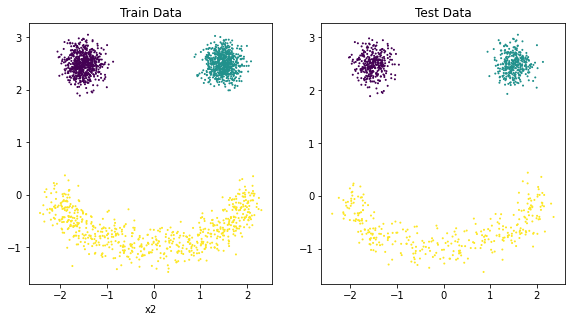

Dataset 2


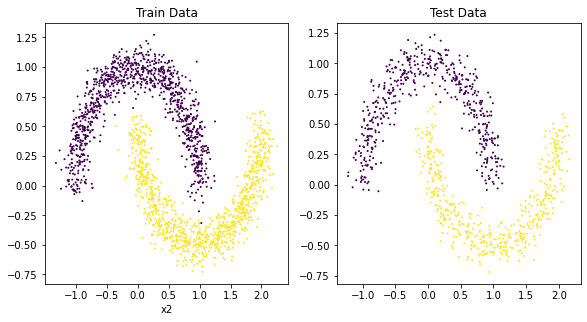

In [6]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [7]:
class CNF(nn.Module):
    def __init__(self, dim, hidden_dim, width, eps):
        super().__init__()
        self.dim = dim
        self.width = width
        self.eps = eps
        
        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim), 
            nn.Tanh(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.Tanh(), 
            nn.Linear(hidden_dim, 2 * dim * width + width)
        )
        
        self.dist = MultivariateNormal(
            torch.zeros(dim).to(device),
            torch.eye(dim).to(device)
        )
    
    def get_dz_dt(self, t, z):
        u, w, b = self.get_uwb(t)
        z_ = z.unsqueeze(0).repeat(self.width, 1, 1)
        return torch.tanh(z_.matmul(w) + b).matmul(u).mean(dim=0)

    def get_uwb(self, t):
        res = self.model(t.unsqueeze(0)).squeeze()
        u = res[: self.width * self.dim].reshape(self.width, 1, self.dim)
        w = res[self.width * self.dim: 2 * self.width * self.dim].reshape(self.width, self.dim, 1)
        b = res[2 * self.width * self.dim: ].reshape(self.width, 1, 1)
        return u, w, b
    
    def get_dlogp_dt(self, f, z):
        trace = torch.zeros(z.size(0)).to(device)
        for i in range(self.dim):
            trace -= torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0][:, i]
        return trace.reshape(z.size(0), 1)
    
    def flow(self, z, t0, t1):
        d_log_p_dt = torch.zeros((z.size(0), 1)).to(device)
        z_t, mlog_det_t = odeint(
            self,
            (z, d_log_p_dt),
            torch.tensor([t1, t0]).to(device),
            atol=self.eps,
            rtol=self.eps,
            method="dopri5"
        )
        return z_t[-1], -mlog_det_t[-1]
    
    def forward(self, x, states):
        with torch.set_grad_enabled(True):
            z = states[0]
            z.requires_grad_(True)
            dz_dt = self.get_dz_dt(x, z)
            d_log_p_z_d_t = self.get_dlogp_dt(dz_dt, z)
            return dz_dt, d_log_p_z_d_t
    
    def loss(self, x, t_0, t_1):
        return -self.get_log_prob(x, t_0, t_1).mean()
    
    def get_log_prob(self, x, t0, t1):
        z, log_det = self.flow(x, t0, t1)
        return log_det + self.dist.log_prob(z).reshape(-1, 1)
    
    def latent(self, x, t_0, t_1):
        with torch.no_grad():
            return self.flow(x, t_0, t_1)[0].cpu().detach().numpy()
        
    def get_prob(self, x, t_0, t_1):
        return self.get_log_prob(x, t_0, t_1).exp().cpu().detach().numpy()

In [8]:
def train(model, train_loader, test_loader, optimizer, epochs, t0, t1):
    train_losses, test_losses = [], []
    for epoch in tqdm(range(epochs)):
        model.train()    
        epoch_losses = []
        for x in train_loader:
            x = x.to(device)
            loss = model.loss(x, t0, t1)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            epoch_losses.append(loss.item())
        train_losses.extend(epoch_losses)

        test_loss = eval_loss(model, test_loader, t0, t1)
        test_losses.append(test_loss)
        # if epoch % 10 == 0:
        #     print(f'Epoch {epoch}, Test loss {test_loss}')
    return train_losses, test_losses

def eval_loss(model, data_loader, t0, t1):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.loss(x, t0, t1)
            total_loss += loss.item() * x.shape[0]
    return total_loss / len(data_loader.dataset)

In [9]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """
    
    model = CNF(train_data.shape[1], hidden_dim=32,
                width=3, eps=1e-5).to(device)
  
    train_data = torch.tensor(train_data, dtype=torch.float)
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

    test_data = torch.tensor(test_data, dtype=torch.float)
    test_dataloader = DataLoader(test_data, batch_size=128)
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_losses = train(model, train_dataloader,
                                      test_dataloader, optim, t0=0.0,
                                      t1=10.0, epochs=100)

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
  
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]

    mesh_xs = torch.tensor(np.stack([x, y], axis=2).reshape(-1, 2),
                           dtype=torch.float)
    mesh_xs = mesh_xs.to(device)
    probs = model.get_prob(mesh_xs, t_0=0.0, t_1=10.0)
    latents = model.latent(train_data.to(device), t_0=0.0, t_1=10.0)

    return train_losses, test_losses, probs, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



100%|██████████| 100/100 [23:20<00:00, 14.01s/it]


Final Test Loss: 1.7203


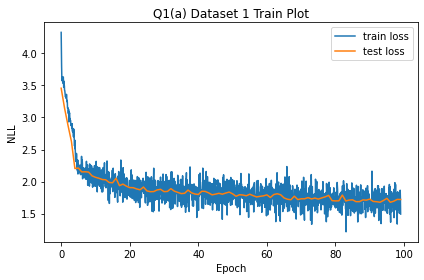

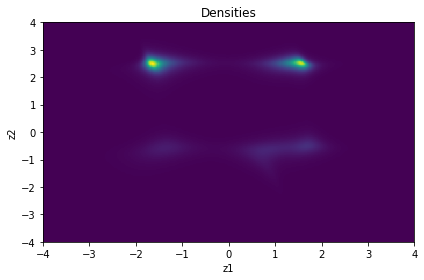

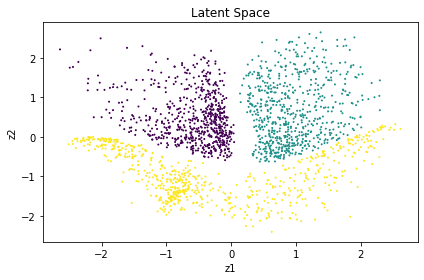

In [10]:
q1_save_results(1, 'a', q1)

100%|██████████| 100/100 [11:11<00:00,  6.72s/it]


Final Test Loss: 1.9240


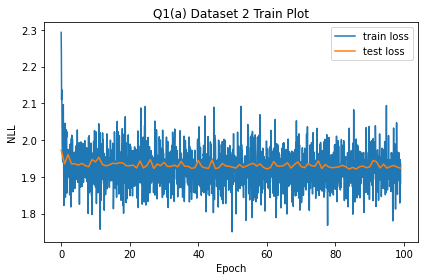

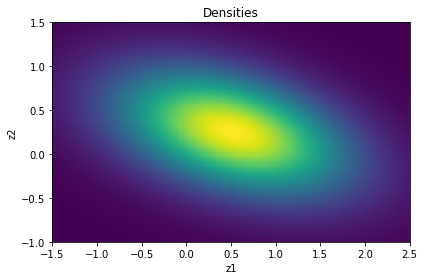

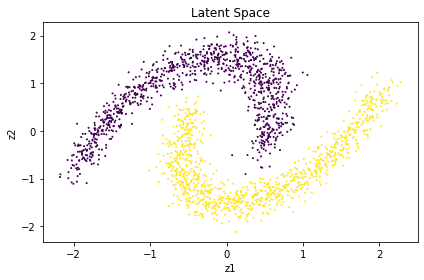

In [11]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [14]:
class HCNF(CNF):
    def get_dlogp_dt(self, f, z):
        v = (2 * torch.randint(0, 2, (self.dim, 1)) - 1).to(torch.float).to(device)

        A = torch.autograd.grad(f.matmul(v).sum(),
                                z, create_graph=True)

        return -A[0].matmul(v)

In [15]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                 used to set different hyperparameters for different datasets, or
                 for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
    model = HCNF(train_data.shape[1], hidden_dim=32, width=3, eps=1e-2).to(device)
  
    train_data = torch.tensor(train_data, dtype=torch.float)
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    
    test_data = torch.tensor(test_data, dtype=torch.float)
    test_dataloader = DataLoader(test_data, batch_size=128)
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_losses = train(model, train_dataloader,
                                      test_dataloader, optim, t0=0.0,
                                      t1=10.0, epochs=20)

    return train_losses, test_losses

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



100%|██████████| 20/20 [09:37<00:00, 28.87s/it]


Final Test Loss: 12.3057


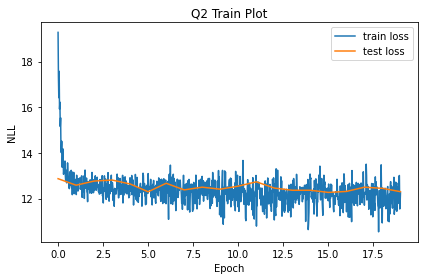

In [16]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)